<a href="https://colab.research.google.com/github/AbhiMalappa/NLP/blob/main/helpdesk_BERT_clf_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fine Tune Bert with Pytorch

In [ ]:
!pip install datasets --quiet
#!pip install -U tensorflow-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
# difference between AutoModel and AutoModelForSequenceClassification
# AutoModelForSequenceClassification is a downstream modifiation of AutoModel, specifically designed for text classification.
# both are same except that AutoModelForSequenceClassification has an additinal classifiaction head on top of AutoModel. Has additional dense layer at the end with output equal to the number of classification labels.

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# initial model checkpoint from huggingface that is used, which is further finetuned for callcenter data
model_ckpt = "bert-base-uncased"

In [ ]:
#import and prepare data
# create a single dataset with test train val
df = pd.read_csv('drive/MyDrive/Colab Notebooks/training_text_calssifiaction.csv') # make sure gdrive is mounted
df = pd.read_csv('drive/MyDrive/Colab Notebooks/v2_training_text_calssifiaction_agent_unprof_updated.csv') # make sure gdrive is mounted

df = df.dropna()
df['label_name'] = df.Category

#lable encoding
label_encoder = LabelEncoder()
df.Category = label_encoder.fit_transform(df.Category)
encoder_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f'encoder mapping{encoder_name_mapping}')

# Rename
df = df.rename(columns={'string_value': 'text'})
df = df.rename(columns={'Category': 'label'})

# test train val split of df
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 777, stratify = df.label)
df_test, df_val= train_test_split(df_test, test_size = 0.33, random_state = 777, stratify = df_test.label)

# convert df to dataset(dict) format that trasformers model can accept
from datasets import Dataset, DatasetDict
dataset = DatasetDict(
    {'train':Dataset.from_pandas(df_train, preserve_index=False),
     'test':Dataset.from_pandas(df_test, preserve_index=False),
     'validation': Dataset.from_pandas(df_val, preserve_index=False)
     }

)

print(df.label_name.value_counts())
print(dataset)

encoder mapping{'agent_unprofessional': 0, 'long_holdtime': 1, 'multiple_contacts_made': 2, 'negative_feedback': 3, 'no_resolution': 4, 'positive_feedback': 5, 'service_portal': 6}
label_name
long_holdtime             3084
no_resolution             2134
service_portal             946
positive_feedback          575
negative_feedback          332
agent_unprofessional       264
multiple_contacts_made     204
Name: count, dtype: int64
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 5277
    })
    test: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 1515
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 747
    })
})


In [ ]:
# tokenize input dataset
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def tokenizes(parm):
    return tokenizer(parm["text"], padding=True, truncation=True, max_length=512) # default max_length=512

tokenized_dataset = dataset.map(tokenizes, batched=True, batch_size=None) # want to pass several samples at once, using batched=True. batch_size=None imp when using batching. We want the max_length to be derived from all the samples.

Map:   0%|          | 0/5277 [00:00<?, ? examples/s]

Map:   0%|          | 0/1515 [00:00<?, ? examples/s]

Map:   0%|          | 0/747 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5277
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1515
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 747
    })
})


In [ ]:
# label2id, id2label needed as part of config modifiation.
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

print(label2id)

{'long_holdtime': 1, 'service_portal': 6, 'no_resolution': 4, 'negative_feedback': 3, 'positive_feedback': 5, 'multiple_contacts_made': 2, 'agent_unprofessional': 0}


In [ ]:
# prepare for model evaluation at later stage

from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [ ]:
# model building

#from transformers import AutoModelForSequenceClassification, AutoConfig
num_labels = len(label2id) # not required when updating model config with custom label2id, id2label
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config.num_labels

7

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Last layer - (classifier): Linear(in_features=768, out_features=5, bias=True ) is the Classification head from BertForSequenceClassification

In [ ]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "agent_unprofessional",
    "1": "long_holdtime",
    "2": "multiple_contacts_made",
    "3": "negative_feedback",
    "4": "no_resolution",
    "5": "positive_feedback",
    "6": "service_portal"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "agent_unprofessional": 0,
    "long_holdtime": 1,
    "multiple_contacts_made": 2,
    "negative_feedback": 3,
    "no_resolution": 4,
    "positive_feedback": 5,
    "service_portal": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embeddi

above - now we have bert model with a classifier head (last line).

In [ ]:
#model training and save model
from transformers import TrainingArguments, Trainer

batch_size = 32
training_dir = "drive/MyDrive/Colab Notebooks/NLP/trained_model/bert_base_train_dir"

#prep train arg
training_args = TrainingArguments( output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm = False
)

#build compiler
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['validation'],
                  tokenizer = tokenizer)

#compile
trainer.train()
#save
#trainer.save_model("drive/MyDrive/Colab Notebooks/NLP/trained_model/Finetune_BERT_for_helpdesk_issue_classification")
trainer.save_model("drive/MyDrive/Colab Notebooks/NLP/trained_model/V2_Finetune_BERT_for_helpdesk_issue_classification_7_class")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-21-22570fd03fa5>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.402389,0.886212,0.860022
2,No log,0.319485,0.918340,0.911029


TrainOutput(global_step=330, training_loss=0.518673613577178, metrics={'train_runtime': 1048.4592, 'train_samples_per_second': 10.066, 'train_steps_per_second': 0.315, 'total_flos': 2776998740428800.0, 'train_loss': 0.518673613577178, 'epoch': 2.0})

In [ ]:
# predict on test data
preds_output = trainer.predict(tokenized_dataset['test'])
preds_output.metrics

{'test_loss': 0.30865466594696045,
 'test_accuracy': 0.9234323432343234,
 'test_f1': 0.9164256611827305,
 'test_runtime': 24.1964,
 'test_samples_per_second': 62.613,
 'test_steps_per_second': 1.984}

In [ ]:
# additinal model performance eval
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = tokenized_dataset['test'][:]['label']

from sklearn.metrics import classification_report
label2id
print(classification_report(y_true, y_pred))

{'long_holdtime': 1,
 'service_portal': 6,
 'no_resolution': 4,
 'negative_feedback': 3,
 'positive_feedback': 5,
 'multiple_contacts_made': 2,
 'agent_unprofessional': 0}

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        53
           1       0.97      0.99      0.98       619
           2       1.00      0.37      0.54        41
           3       0.67      0.48      0.56        67
           4       0.89      0.97      0.93       429
           5       0.85      0.91      0.88       116
           6       0.98      1.00      0.99       190

    accuracy                           0.92      1515
   macro avg       0.87      0.75      0.79      1515
weighted avg       0.92      0.92      0.92      1515



<Figure size 500x500 with 0 Axes>

<Axes: >

Text(33.081597222222214, 0.5, 'Actual')

Text(0.5, 25.581597222222214, 'Predicted')

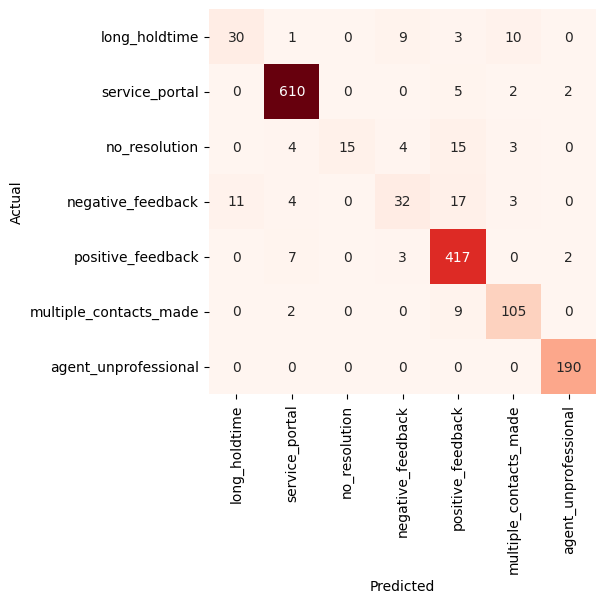

In [ ]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
#text = "the person ansering the phone was very impatient"
#text = "very happy with the service"
#
#def get_prediction(text):
#    input_encoded = tokenizer(text, return_tensors='pt').to(device)
#
#    with torch.no_grad():
#        outputs = model(**input_encoded)
#
#    logits = outputs.logits
#
#    pred = torch.argmax(logits, dim=1).item()
#    return id2label[pred]
#
#get_prediction(text)

In [ ]:
# create pipeline for prediciton
from transformers import pipeline
clf = pipeline('text-classification', model= "drive/MyDrive/Colab Notebooks/NLP/trained_model/Finetune_BERT_for_helpdesk_issue_classification")
clf = pipeline('text-classification', model= "drive/MyDrive/Colab Notebooks/NLP/trained_model/V2_Finetune_BERT_for_helpdesk_issue_classification_7_class")

Device set to use cuda:0
Device set to use cuda:0


In [ ]:
# call on pipeline
clf([
    "hello, how are you?",
    "had to sit 42 min before reaching someone",
    "My problem wasn't fixed but I had to email someone else who sent me a reply with instructions on how to try to correct it myself.  This is after I have already had 5-6 other IT people try to fix it.  Not very helpful.",
    "the person i spoke to did not speak well",
    "the person i spoke to did not have good communication",
    "i had to call back again",
    "i dont like your company "
    ])

[{'label': 'positive_feedback', 'score': 0.46648383140563965},
 {'label': 'long_holdtime', 'score': 0.9796583652496338},
 {'label': 'no_resolution', 'score': 0.9647257924079895},
 {'label': 'negative_feedback', 'score': 0.2824115455150604},
 {'label': 'agent_unprofessional', 'score': 0.27807244658470154},
 {'label': 'multiple_contacts_made', 'score': 0.3342064917087555},
 {'label': 'negative_feedback', 'score': 0.4032457172870636}]